# Employees Sample Database Exploration

https://dev.mysql.com/doc/employee/en/employees-installation.html
https://github.com/datacharmer/test_db

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import warnings
from IPython import display
import pandas_profiling
from config import password
import mysql.connector
from mysql.connector import errorcode

# Options and Settings

In [2]:
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.size'] = 12
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('display.precision', 5)
pd.set_option('expand_frame_repr', True)
warnings.simplefilter('ignore')  

path_directory = os.getcwd()                           # get the current working directory
warnings.simplefilter('ignore')                        # ignore simple warnings

# Import Employees Schema

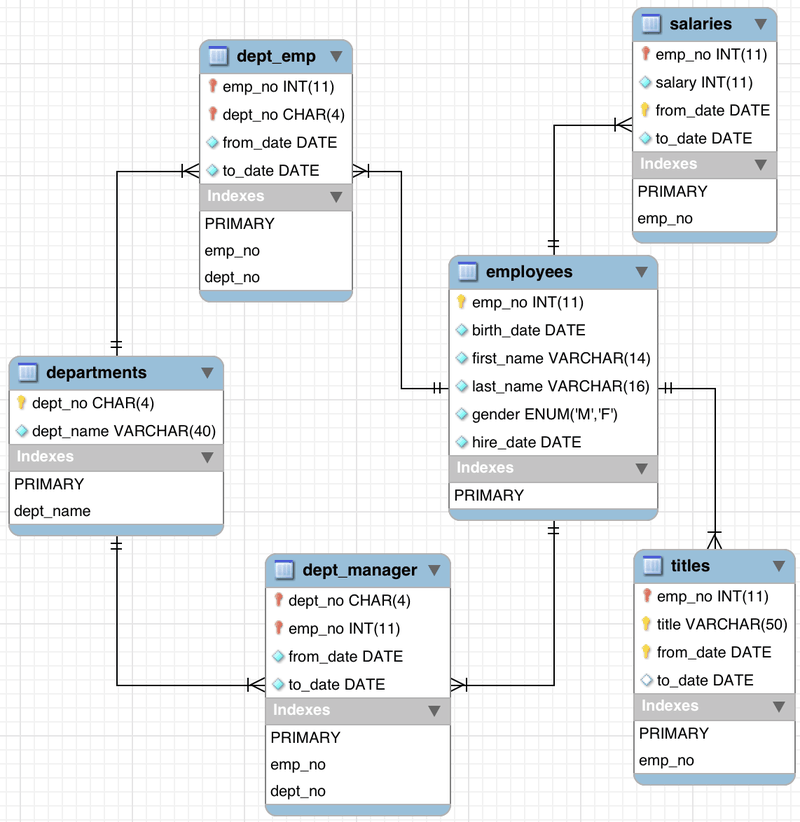

In [3]:
image_path = os.path.join(path_directory, 'images', 'employees-schema.png')

display.Image(image_path)

# Connect To Employees Database

In [4]:
# define connection arguments
config = {
           'user': 'root',
           'password': password,
           'host': '127.0.0.1',
           'database': 'employees',
           'port': 3306,
           'raise_on_warnings': True
         }

# create connection to database
cnx = mysql.connector.connect(**config)

# open a cursor to perform database queries
cur = cnx.cursor()



def extract(sql_query: str):
  '''
  Helper Function For Extracting Data From Employees Database

  Parameters
  ----------

  query: str
    SQL query to execute

  
  Returns

  df: pd.DataFrame
    returns a pandas dataframe
  
  '''
  try:
    cur.execute(sql_query)
    records = cur.fetchall()
    df = pd.DataFrame(data=records)
  except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
      print('wrong username or password')
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
      print('Database does not exist')
    else:
      print(err)
  else:
    cnx.close()

  return df

# Extract Data

In [5]:
query = '''
           with 
	employees_table_tbl as (select
								   distinct 
									       e.emp_no, 
									       e.birth_date, 
                                           e.first_name,
                                           e.last_name,
                                           e.gender,
                                           e.hire_date
					         from employees e
					       ),
	
    department_employees_tbl as (select 
								       distinct
                                               de.emp_no,
                                               de.dept_no,
                                               de.from_date,
                                               de.to_date
								  from dept_emp de
						        ),
                            
	departments_tbl as (select
							  distinct
                                      d.dept_no,
                                      d.dept_name
					    from departments d
				      ),
                   
	merged_employees_departments_tbl as (select
                                               distinct 
                                                       et.emp_no,
                                                       count(et.emp_no) over () as employees_count,
													   et.first_name,
                                                       et.last_name,
                                                       et.gender,
                                                       count(*) over (partition by et.gender) as employees_count_by_gender,
									                   et.birth_date,
                                                       timestampdiff(year, et.birth_date, current_date) as employee_age,
                                                       et.hire_date,
                                                       timestampdiff(year, et.hire_date, current_date) as employee_work_experience,
                                                       det.dept_no,
                                                       dt.dept_name,
                                                       count(*) over (partition by dt.dept_name) as dept_name_count,
                                                       det.from_date,
                                                       det.to_date,
                                                       timestampdiff(year, det.from_date, det.to_date) as years_spent_per_department
										  from employees_table_tbl et
                                          left join department_employees_tbl det on et.emp_no = det.emp_no
                                          left join departments_tbl dt on det.dept_no = dt.dept_no
                                          where to_date != (select max(de.to_date) from dept_emp de)
									    ),
                                        
	transformed_tbl as (select
							   distinct  
                                       emp_no,
                                       employees_count,
                                       first_name,
                                       last_name,
                                       gender,
                                       employees_count_by_gender,
                                       birth_date,
                                       rank() over (order by employee_age desc) as employee_age_rank,
                                       employee_age,
                                       min(employee_age) over () as minimum_employee_age,
                                       avg(employee_age) over () as average_employee_age,
                                       max(employee_age) over () as maximum_employee_age,
                                       hire_date,
                                       employee_work_experience,
                                       min(employee_work_experience) over () minimum_work_experience,
                                       avg(employee_work_experience) over () average_work_experience,
                                       max(employee_work_experience) over () maximum_work_experience,
                                       dept_no,
                                       dept_name,
                                       dept_name_count,
                                       from_date,
                                       to_date,
                                       years_spent_per_department,
                                       dense_rank() over (order by years_spent_per_department desc) as experience_rank
						from merged_employees_departments_tbl)
                                        
select * from transformed_tbl;

        '''

df = extract(query)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,81619,91479,Gen,Aloisi,M,54736,1965-01-12,89161,57,57,63.6741,70,1985-03-12,37,22,32.1858,37,d005,Development,24321,1985-03-12,2002-07-25,17,1
1,229162,91479,Annemarie,Lorie,M,54736,1964-08-02,82166,58,57,63.6741,70,1985-04-09,37,22,32.1858,37,d004,Production,20181,1985-04-09,2002-06-23,17,1
2,204324,91479,Kasidit,Herbst,F,36743,1963-11-06,82166,58,57,63.6741,70,1985-02-10,37,22,32.1858,37,d005,Development,24321,1985-02-10,2002-08-01,17,1
3,51185,91479,Kazuhito,Emden,M,54736,1964-01-12,82166,58,57,63.6741,70,1985-04-29,37,22,32.1858,37,d004,Production,20181,1985-04-29,2002-06-05,17,1
4,429386,91479,Aleksander,Masaki,F,36743,1963-08-30,75141,59,57,63.6741,70,1985-02-03,37,22,32.1858,37,d007,Sales,14544,1985-02-03,2002-08-01,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,457322,91479,Youssef,Flasterstein,M,54736,1953-02-09,4650,69,57,63.6741,70,1996-09-26,26,22,32.1858,37,d003,Human Resources,4888,1998-12-05,1999-07-20,0,18
91475,205066,91479,Sashi,Munos,M,54736,1953-06-12,4650,69,57,63.6741,70,1989-11-06,32,22,32.1858,37,d003,Human Resources,4888,1996-02-27,1997-01-11,0,18
91476,272163,91479,Ronghao,Ashish,M,54736,1953-03-22,4650,69,57,63.6741,70,1988-06-30,34,22,32.1858,37,d003,Human Resources,4888,1995-09-10,1996-08-11,0,18
91477,268090,91479,Seongbae,Panwar,M,54736,1953-04-27,4650,69,57,63.6741,70,1997-05-15,25,22,32.1858,37,d003,Human Resources,4888,1998-10-05,1999-04-03,0,18
